In [1]:
import numpy as np

# 단순한 계층 구현하기
곱셈 노드: `MulLayer`, 덧셈 노드: `AddLayer`

## 곱셈 계층

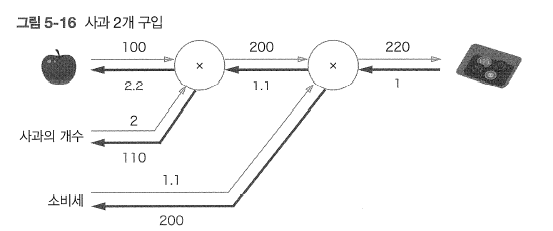

In [2]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
    
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y

        return out
    
    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x

        return dx, dy

In [3]:
apple = 100
apple_num = 2
tax = 1.1

# 계층들
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# 순전파
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)


# 역전파
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

# 결과 출력
print(price) # 220
print(dapple, dapple_num, dtax) # 2.2, 110, 200

220.00000000000003
2.2 110.00000000000001 200


## 덧셈 계층

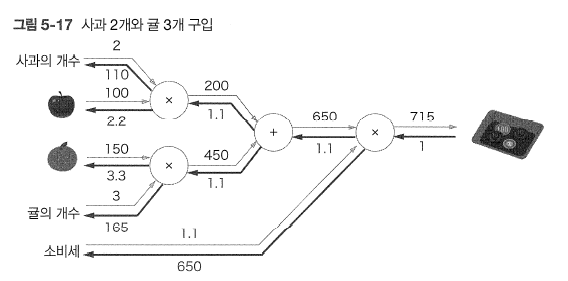

In [4]:
class AddLayer:
    def __init__(self): # 초기화 할 변수가 없음
        pass
    
    def forward(self, x, y):
        out = x + y
        return out
    
    def backward(self, dout): # 미분 값을 그냥 흘린다!
        dx = dout * 1
        dy = dout * 1

        return dx, dy

In [5]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# 계층들
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# 순전파
apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(all_price, tax)

# 역전파
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(price) # 715
print(dapple, dapple_num, dorange, dorange_num, dtax) # 110, 2.2, 3.3, 165, 650

715.0000000000001
2.2 110.00000000000001 3.3000000000000003 165.0 650


# 활성화 함수 계층 구현하기

## ReLU 계층

In [6]:
class ReLU:
    def __init__(self):
        self.mask = None
    
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

## Sigmoid 계층

In [7]:
class Sigmoid:
    def __init__(self):
        self.out = None
    
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out 

        return dx

# Affine/Softmax 계층 구현하기

## Affine 계층

In [19]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
    
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b

        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        return dx

## Softmax-with-loss 계층

In [9]:
def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a - c)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a

    return y

In [10]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        

    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [11]:
class SoftmaxWithLoss:
    def __init__(self):
      self.loss = None
      self.y_hat = None
      self.y = None
    
    def forward(self, x, y):
        self.y = y
        self.y_hat = softmax(x)
        self.loss = cross_entropy_error(self.y_hat, self.y)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.y.shape[0]
        dx = (self.y_hat - self.y) / batch_size

        return dx

# 오차역전파법 구현하기

In [12]:
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val
        it.iternext()   
        
    return grad

In [30]:
from collections import OrderedDict

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params["W1"] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params["b1"] = np.zeros(hidden_size)
        self.params["W2"] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params["b2"] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict() # dictionary 데이터의 순서를 보장받을 수 있다
        self.layers["Affine1"] = Affine(self.params["W1"], self.params["b1"])
        self.layers["ReLU1"] = ReLU()
        self.layers["Affine2"] = Affine(self.params["W2"], self.params["b2"])
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, y):
        y_hat = self.predict(x)

        return self.last_layer.forward(y_hat, y)

    def accuracy(self, x, y):
        y_hat = self.predict(x)
        y_hat = np.argmax(y_hat, axis=1)
        if y.ndim != 1:
            y = np.argmax(y, axis=1)

        accuracy = np.sum(y_hat == y) / float(x.shape[0])

        return accuracy

    def numerical_gradient(self, x, y):
        loss_W = lambda W: self.loss(x, y)

        grads = {}
        grads["W1"] = numerical_gradient(loss_W, self.params["W1"])
        grads["b1"] = numerical_gradient(loss_W, self.params["b1"])
        grads["W2"] = numerical_gradient(loss_W, self.params["W2"])
        grads["b2"] = numerical_gradient(loss_W, self.params["b2"])

        return grads

    def gradient(self, x, y):
        # 순전파
        self.loss(x, y)

        # 역전파
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads["W1"] = self.layers["Affine1"].dW
        grads["b1"] = self.layers["Affine1"].db
        grads["W2"] = self.layers["Affine2"].dW
        grads["b2"] = self.layers["Affine2"].db

        return grads

In [22]:
def one_hot_encoder(dataset, n_labels=10):
    one_hot = np.zeros((len(dataset), n_labels))

    for i, idx in enumerate(dataset):
        one_hot[i, idx] = 1
    return np.array(one_hot)

## 기울기 검증하기

수치 미분은 느리므로 오차역전파법을 사용한다. <br>
대신 수치 미분은 오차역전파법을 정확히 구현했는지 확인할 때 필요하다.

In [28]:
from tensorflow import keras

mnist = keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train , X_test = X_train/255., X_test/255.
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])
y_train, y_test = one_hot_encoder(y_train), one_hot_encoder(y_test)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

X_batch = X_train[:3]
y_batch = y_train[:3]

grad_numerical = network.numerical_gradient(X_batch, y_batch)
grad_backprop = network.gradient(X_batch, y_batch)

for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(f"{key}: {diff}")

W1: 0.00013455573861496597
b1: 0.0010308606531571646
W2: 0.0030033132430225514
b2: 0.0666666667867928


## 오차역전파법을 사용한 학습 구현하기

In [35]:
from tensorflow import keras


mnist = keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train , X_test = X_train/255., X_test/255.
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])
y_train, y_test = one_hot_encoder(y_train), one_hot_encoder(y_test)


network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = X_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    X_batch = X_train[batch_mask]
    y_batch = y_train[batch_mask]

    grad = network.gradient(X_batch, y_batch)

    # 갱신
    for key in ("W1", "b1", "W2", "b2"):
        network.params[key] -= learning_rate * grad[key]

    loss = network.loss(X_batch, y_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(X_train, y_train)
        test_acc = network.accuracy(X_test, y_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

0.15028333333333332 0.1549
0.09751666666666667 0.0974
0.09751666666666667 0.0974
0.09871666666666666 0.098


<ipython-input-9-4931d8096efd>:3: RuntimeWarning: invalid value encountered in subtract
  exp_a = np.exp(a - c)


0.09871666666666666 0.098
0.09871666666666666 0.098
0.09871666666666666 0.098
0.09871666666666666 0.098
0.09871666666666666 0.098
0.09871666666666666 0.098
0.09871666666666666 0.098
0.09871666666666666 0.098
0.09871666666666666 0.098
0.09871666666666666 0.098
0.09871666666666666 0.098
0.09871666666666666 0.098
0.09871666666666666 0.098
